### Anomaly detection using Deep Learning and Autoencoders, full example with ECG (EchoCardioGram)

As you may know, we use deep learning algorithms to resolve classification or regression problems. We teach the neural network with a lot of data and answers, and we get back the rules to get those answers.

For the problem that we are facing, finding anomalies in your data, we could use the capacity of learning from a deep learning model. We can teach it with a lot of "normal" (not anomaly) data, and then, ask the model if the new data is "normal" or "anomaly". The technique that we will use for that is called __"autoencoders"__. I knew this process was use for images, to denoise (clean the image), compress, apply filters,... But when Travis told me about the problem, I researched a little and I found that  is also used for anomalies detection. 



The entire process is based in compress (__encoder__) and decompress (__decoder__) our data. Using neural networks, we are reducing (__encoder__) our data to a minimal vector (__compressed representation__), where the most essential information is still present. Then, using the opposite process (__decoder__), we regenerate the data from that minimal vector. Finally, we measure how different is the original data from the reconstructed one. See the example below, where our model is able to compress and reconstruct and image with the number 2 on it.

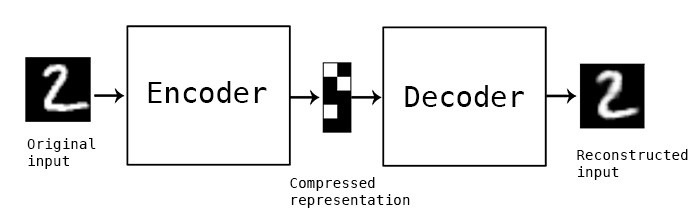


  

If we teach our model with only one kind of data, (like images with the number 2 in the example above), the model is going to be an "expert" in this data. It will try to encode/decode always thinking about what it learned. In the example above, if we try to "predict" an image with the number 1, with the model that we taught with images with numbers 2, it will fail, and we will have a big "error" when we compare the original image with reconstructed one. But if we "predict" an image with the number 2 (or a shape similar to number 2), the model will do almost perfect (it was trained for that) and the error will be very low. So we just need to find the right error threshold to call a reconstructed image good (normal) or bad (anomaly).

Now think about in a continuous  function, where there is a repetitive pattern, like an ECG (ElectroCardioGram). Most of the time, there is a pattern (normal data), that it is repeated over time. 


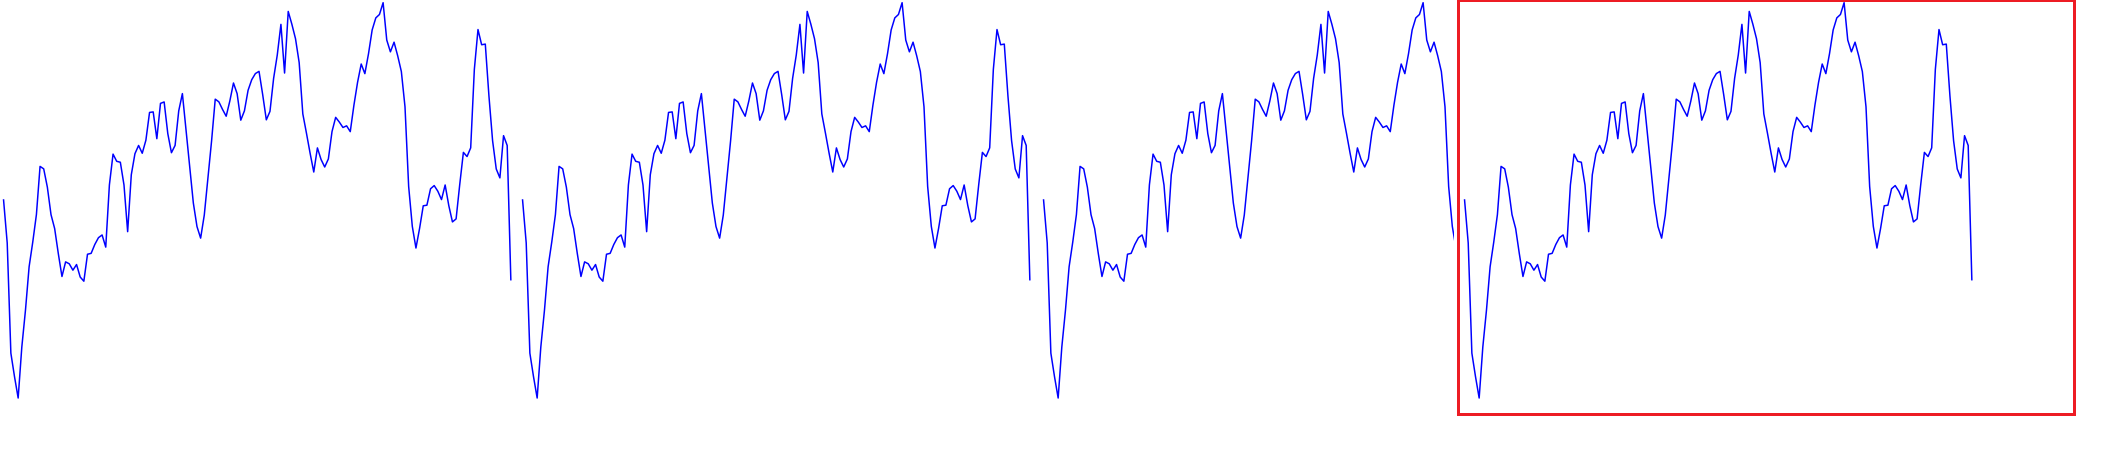


We can teach our model with this pattern (would be one heartbeat). And then, using this information, we can predict if new data is normal (small error when reconstructed). Like in the image bellow, where  you can see that both graphs are very similar.

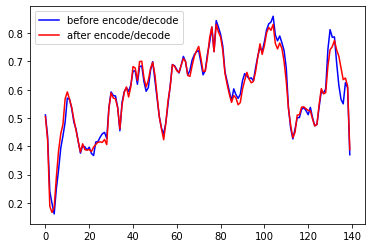

Or we can predict that it is an anomaly (big error when reconstructed). You can see the differences below.

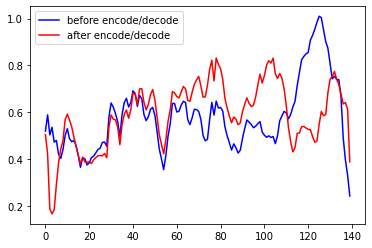

# Let see the entire ECG example

Now that we have an idea how the Autoencoders work, let me show you how I implemented the entire model for the ECG data. I think you could use something similar to solve your problem.

First we load all the needed libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.utils import img_to_array
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd



We load the dataset (attached on the email). And rename the columns to be able to work with them.

In [2]:
df = pd.read_csv('ECG5000/ecg_final.csv', header=None)
df = df.add_prefix('c')

In [3]:
df.head(3)

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c131,c132,c133,c134,c135,c136,c137,c138,c139,c140
0,1.0,-0.113,-2.83,-3.77,-4.35,-4.38,-3.47,-2.18,-1.820,-1.250,...,0.16,0.792,0.934,0.797,0.5790,0.258,0.228,0.123,0.925,0.193
1,1.0,-1.100,-4.00,-4.29,-4.51,-4.02,-3.23,-1.57,-0.992,-0.755,...,0.56,0.538,0.657,0.787,0.7240,0.556,0.476,0.774,1.120,-1.440
2,1.0,-0.567,-2.59,-3.87,-4.58,-4.19,-3.15,-1.74,-1.490,-1.180,...,1.28,0.886,0.531,0.311,-0.0219,-0.714,-0.532,0.321,0.904,-0.422


In [4]:
df.shape

(5000, 141)

The dataset has 5,000 samples, with 140 parameters to measure the heart activity. The column "c0" is the target, with 5 classes. Class "1" means "normal" heartbeat. Anything different means "anomaly"

In [5]:
df['c0'].value_counts()

1.0    2919
2.0    1767
4.0     194
3.0      96
5.0      24
Name: c0, dtype: int64

I am going to split the data in test (80%) and training(20%). Using all the columns as data and just column "C0" as label.

In [6]:
train_data, test_data, train_labels, test_labels = train_test_split(df.values, df.values[:,0:1],test_size=0.2, random_state=42)

Because machine learning models worked better with scaled data, we are going to scale our data using MinMaxScaler. MinMaxScaler preserve the shape of the original distribution, doesn't reduce the importance of outliers and it uses the range between 0 and 1.

In [7]:
scaler = MinMaxScaler()
data_scaled = scaler.fit(train_data)

train_data_scaled = data_scaled.transform(train_data)
test_data_scaled = data_scaled.transform(test_data)

Now we will split "normal" and "anomaly" data. "C0" = 0 --> Normal,    "C0" > 0 --> Anomaly

In [8]:
normal_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 > 0').values[:,1:]

normal_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 > 0').values[:,1:]

In [9]:
print("Normal Train Data",normal_train_data.shape)
print("Normal Test Data",normal_test_data.shape)

print("Anomaly Train Data",anomaly_train_data.shape)
print("Anomaly Test Data", anomaly_test_data.shape)

Normal Train Data (2333, 140)
Normal Test Data (586, 140)
Anomaly Train Data (1667, 140)
Anomaly Test Data (414, 140)


We can plot some "normal" samples to see how they look. They all should look similar

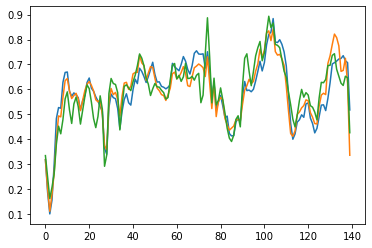

In [10]:
plt.plot(normal_train_data[0])
plt.plot(normal_train_data[1])
plt.plot(normal_train_data[2])

Also we can plot some "anomalies". As you can see they are not all similar.

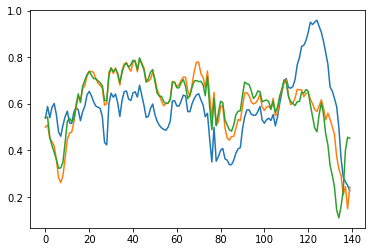

In [27]:
plt.plot(anomaly_train_data[1])
plt.plot(anomaly_train_data[2])
plt.plot(anomaly_train_data[3])

Now, we create our model, a neural network with 4 layers to encode and another 4 to decode. We start reducing from the original 140 parameters to 64,32,16 and 8 units. Then, we reverse the process, 16,32,64 and finally 140 units as the original data. We also use "Adam" optimizer algorithm  and "MAE" (Mean Absolute Error) as loss function when we compile or model.

In [12]:
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(64,activation='relu'),
            tf.keras.layers.Dense(32,activation='relu'),
            tf.keras.layers.Dense(16,activation='relu'),
            tf.keras.layers.Dense(8,activation='relu')])
              
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(16,activation='relu'),
            tf.keras.layers.Dense(32,activation='relu'),
            tf.keras.layers.Dense(64,activation='relu'),
            tf.keras.layers.Dense(140,activation='sigmoid')])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    
model = AutoEncoder()
model.compile(optimizer='adam', loss='mae')

And we train the model with our normal_train_data. For supervise learning, we should pass the labels data for the training, but this time, we dont care about the labels, we just want to encode and decode, so we just use again the normal_train_data as dummy labels. We repeat the learning process 150 times (epochs) and we use all the data for validation.

In [13]:
history = model.fit(normal_train_data, normal_train_data,
                   epochs=150,
                   batch_size=128,
                   validation_data=(test_data_scaled[:,1:], test_data_scaled[:,1:]),
                   shuffle=True)

Epoch 1/150
19/19 [==============================] - 1s 12ms/step - loss: 0.1247 - val_loss: 0.1178
Epoch 2/150
19/19 [==============================] - 0s 3ms/step - loss: 0.0883 - val_loss: 0.0846
Epoch 3/150
19/19 [==============================] - 0s 3ms/step - loss: 0.0550 - val_loss: 0.0776
Epoch 4/150
19/19 [==============================] - 0s 4ms/step - loss: 0.0480 - val_loss: 0.0761
Epoch 5/150
19/19 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0753
Epoch 6/150
19/19 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0751
Epoch 7/150
19/19 [==============================] - 0s 4ms/step - loss: 0.0460 - val_loss: 0.0744
Epoch 8/150
19/19 [==============================] - 0s 4ms/step - loss: 0.0457 - val_loss: 0.0733
Epoch 9/150
19/19 [==============================] - 0s 5ms/step - loss: 0.0455 - val_loss: 0.0727
Epoch 10/150
19/19 [==============================] - 0s 5ms/step - loss: 0.0452 - val_loss: 0.0716
Epoch 11

19/19 [==============================] - 0s 4ms/step - loss: 0.0247 - val_loss: 0.0495
Epoch 84/150
19/19 [==============================] - 0s 3ms/step - loss: 0.0248 - val_loss: 0.0502
Epoch 85/150
19/19 [==============================] - 0s 4ms/step - loss: 0.0247 - val_loss: 0.0497
Epoch 86/150
19/19 [==============================] - 0s 3ms/step - loss: 0.0248 - val_loss: 0.0495
Epoch 87/150
19/19 [==============================] - 0s 4ms/step - loss: 0.0248 - val_loss: 0.0496
Epoch 88/150
19/19 [==============================] - 0s 3ms/step - loss: 0.0247 - val_loss: 0.0496
Epoch 89/150
19/19 [==============================] - 0s 3ms/step - loss: 0.0246 - val_loss: 0.0498
Epoch 90/150
19/19 [==============================] - 0s 3ms/step - loss: 0.0246 - val_loss: 0.0500
Epoch 91/150
19/19 [==============================] - 0s 3ms/step - loss: 0.0245 - val_loss: 0.0497
Epoch 92/150
19/19 [==============================] - 0s 3ms/step - loss: 0.0246 - val_loss: 0.0500
Epoch 93/150


So now, we have our model trained to recreate "normal" data. As we saw before, the model will be able to "encode & decode" any normal data, and the result will be very similar.

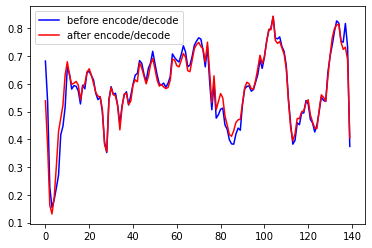

In [14]:
encoder_out = model.encoder(normal_test_data).numpy()
decoder_out = model.decoder(encoder_out).numpy()

plt.plot(normal_test_data[0],'b',label="before encode/decode")
plt.plot(decoder_out[0],'r', label="after encode/decode")
plt.legend(loc="upper left")


But, if we try to "encode & decode" data with anomalies, the model will fail

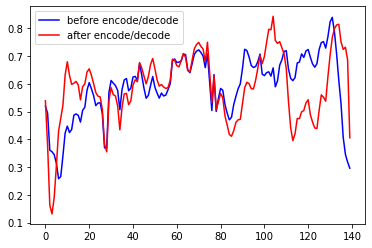

In [15]:
plt.plot(anomaly_test_data[0],'b',label="before encode/decode")
plt.plot(decoder_out[0],'r',label="after encode/decode")
plt.legend(loc="upper left")

We need to find the thresold to messure when the results are bad enough to be called "anomaly"

We are going to predict the entire "normal" dataset and measure all the errors (loss)

In [16]:
reconstructions = model.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstructions,normal_test_data)


19/19 [==============================] - 0s 888us/step


And then create a histogram with the loss results.  

(array([ 32., 105., 138.,  96.,  58.,  48.,  31.,  15.,  20.,  15.,   6.,
          5.,   6.,   3.,   2.,   0.,   2.,   0.,   0.,   1.,   1.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.00988123, 0.01341109, 0.01694095, 0.02047081, 0.02400067,
        0.02753053, 0.03106039, 0.03459025, 0.03812011, 0.04164997,
        0.04517983, 0.04870969, 0.05223955, 0.05576941, 0.05929927,
        0.06282913, 0.06635899, 0.06988885, 0.07341871, 0.07694857,
        0.08047844, 0.0840083 , 0.08753816, 0.09106802, 0.09459788,
        0.09812774, 0.1016576 , 0.10518746, 0.10871732, 0.11224718,
        0.11577704]),
 <BarContainer object of 30 artists>)

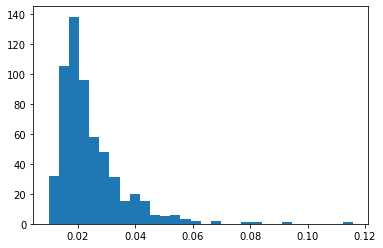

In [28]:
plt.hist(train_loss.numpy(), bins=30)

In [29]:
print("mean:",np.mean(train_loss))
print("std:",np.std(train_loss))

mean: 0.024297218413090124
std: 0.011318440032697212


As you can see above, the mean is ~0.02 with a Standard Deviation of ~0.011. Depending on the requirements, the "normal" data threshold  could be adding 2, 3... Standard Deviation to the mean. Let's take 2 for this example.

In [19]:
treshold = np.mean(train_loss) + 2*np.std(train_loss)
print(treshold)

0.04693409847848455


So, any loss above ~0.047 will be considered "anomaly". Let's calculate the error for all the anomaly data in our dataset.


In [20]:
reconstructions_a = model.predict(anomaly_test_data)
train_loss_a = tf.keras.losses.mae(reconstructions_a, anomaly_test_data)


13/13 [==============================] - 0s 831us/step


And create the histogram also

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  7., 12., 27., 33., 51., 42.,
        52., 47., 39., 17., 24., 19., 14.,  7.,  3.,  3.,  4.,  2.,  2.,
         0.,  1.,  0.,  0.,  1.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.01443197, 0.01800338, 0.02157479, 0.0251462 , 0.0287176 ,
        0.03228901, 0.03586042, 0.03943183, 0.04300323, 0.04657464,
        0.05014605, 0.05371745, 0.05728886, 0.06086027, 0.06443168,
        0.06800308, 0.07157449, 0.0751459 , 0.0787173 , 0.08228871,
        0.08586012, 0.08943153, 0.09300293, 0.09657434, 0.10014575,
        0.10371716, 0.10728856, 0.11085997, 0.11443138, 0.11800278,
        0.12157419, 0.1251456 , 0.12871701, 0.13228841, 0.13585982,
        0.13943123, 0.14300264, 0.14657404, 0.15014545, 0.15371686,
        0.15728826, 0.16085967, 0.16443108, 0.16800249, 0.17157389,
        0.1751453 , 0.17871671, 0.18228811, 0.18585952, 0.18943093,
        0.19300234]),
 <BarContainer

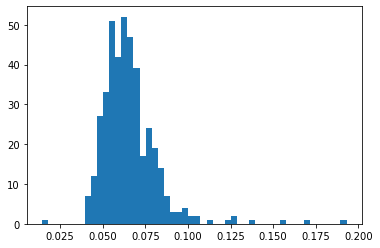

In [21]:
plt.hist(train_loss_a.numpy(), bins=50)

In [22]:
print("mean:",np.mean(train_loss_a))
print("std:",np.std(train_loss_a))

mean: 0.06569969032560016
std: 0.016982203715068124


We can see that the mean of the "anomaly" data is ~0.07. Higher than the "normal" data mean.

If we put both graphics together, we can understand better where the threshold, the "normal" data and "anomalies" are.

<function matplotlib.pyplot.show(close=None, block=None)>

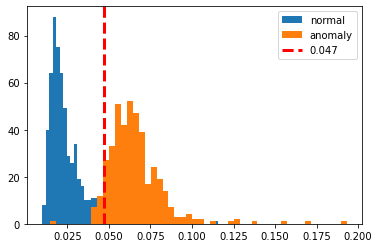

In [23]:
plt.hist(train_loss.numpy(), bins=50, label='normal')
plt.hist(train_loss_a.numpy(), bins=50, label='anomaly')
plt.axvline(treshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(treshold))
plt.legend(loc='upper right')
plt.show